# Contrastive Learning — Data Visualization

This notebook loads the standardized dataset `ztf_image_search_results_full_standardized.csv` and produces a suite of visualizations: univariate (histograms, KDEs, boxplots), bivariate (scatter, pairplots, correlation heatmap), and multivariate embeddings (PCA, t-SNE/UMAP). Each main visualization step is placed in its own cell for clarity.

Notes:
- The standardized file was produced earlier from the cleaned dataset. For visual exploration it is fine to use, but avoid using precomputed standardized data for final model training without refitting scalers on the train split.
- Large datasets may require sampling before plotting to keep plots responsive.

In [1]:
# Imports and load standardized dataset
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
    _has_umap = True
except Exception:
    _has_umap = False

sns.set(style='whitegrid', context='notebook')
DATA_PATH = 'ztf_image_search_results_full_standardized.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f'{DATA_PATH} not found in workspace. Make sure the standardized file exists.')
df = pd.read_csv(DATA_PATH)
print('Loaded rows,cols:', df.shape)
df.head()

c:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded rows,cols: (62368, 42)


,ra,dec,infobits,field,ccdid,qid,rcid,fid,filtercode,pid,...,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4,ipac_pub_date,ipac_gid
0,-1.149415,1.530960,3.271612,0.0,16,1,60,2,zr,769412526015,...,-1.145394,1.533955,-1.154038,1.527879,-1.153409,1.527906,-1.144992,1.533965,2020-12-09 00:00:00+00,2
1,-1.541840,1.124622,-0.292168,0.0,16,3,62,2,zr,1503405246215,...,-1.539070,1.128810,-1.545208,1.120335,-1.544380,1.120568,-1.538590,1.128870,2022-09-07 00:00:00+00,2
2,-1.550309,1.524426,-0.292168,0.0,16,2,61,2,zr,1504338726115,...,-1.546397,1.528636,-1.554966,1.520063,-1.554021,1.520241,-1.545751,1.528666,2022-09-07 00:00:00+00,2
3,-1.542016,0.238707,-0.292168,0.0,12,3,46,2,zr,1521276364615,...,-1.541777,0.243002,-1.542693,0.234344,-1.542135,0.234563,-1.541345,0.243051,2022-09-07 00:00:00+00,3
4,-1.541997,0.237082,-0.292168,0.0,12,3,46,1,zg,1519302464615,...,-1.541772,0.241370,-1.542673,0.232721,-1.542138,0.232894,-1.541332,0.241424,2021-06-30 00:00:00+00,1


In [3]:
# Quick summary statistics and missingness
print('Columns:', df.shape[1])
print('Data types:')
print(df.dtypes.value_counts())
print('Missing per column:')
print(df.isnull().sum().sort_values(ascending=False).head(20))
print('Numeric describe:')
display(df.select_dtypes(include=['number']).describe().T)


Columns: 42
Data types:
float64    27
int64      10
object      5
Name: count, dtype: int64
Missing per column:
ra             0
dec            0
infobits       0
field          0
ccdid          0
qid            0
rcid           0
fid            0
filtercode     0
pid            0
nid            0
expid          0
itid           0
imgtype        0
imgtypecode    0
obsdate        0
obsjd          0
exptime        0
filefracday    0
seeing         0
dtype: int64
Numeric describe:


,count,mean,std,min,25%,50%,75%,max
ra,62368.0,5.960684e-15,1.000008e+00,-1.574425e+00,-6.683659e-01,-2.176854e-01,6.653766e-01,1.570212e+00
dec,62368.0,4.329243e-16,1.000008e+00,-1.559961e+00,-6.545427e-01,-2.225677e-01,6.620686e-01,1.577181e+00
infobits,62368.0,-4.465956e-17,1.000008e+00,-2.921682e-01,-2.921682e-01,-2.921682e-01,-2.921682e-01,5.276239e+00
field,62368.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ccdid,62368.0,8.463459e+00,4.586164e+00,1.000000e+00,5.000000e+00,8.000000e+00,1.200000e+01,1.600000e+01
qid,62368.0,2.501331e+00,1.118042e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
rcid,62368.0,3.135517e+01,1.839405e+01,0.000000e+00,1.600000e+01,3.100000e+01,4.700000e+01,6.300000e+01
fid,62368.0,1.765232e+00,6.117556e-01,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
pid,62368.0,1.611541e+12,7.508763e+11,4.482747e+11,8.521514e+11,1.500295e+12,2.183406e+12,3.067223e+12
nid,62368.0,1.611196e+03,7.508777e+02,4.480000e+02,8.520000e+02,1.500000e+03,2.183000e+03,3.067000e+03


Numeric columns count: 37


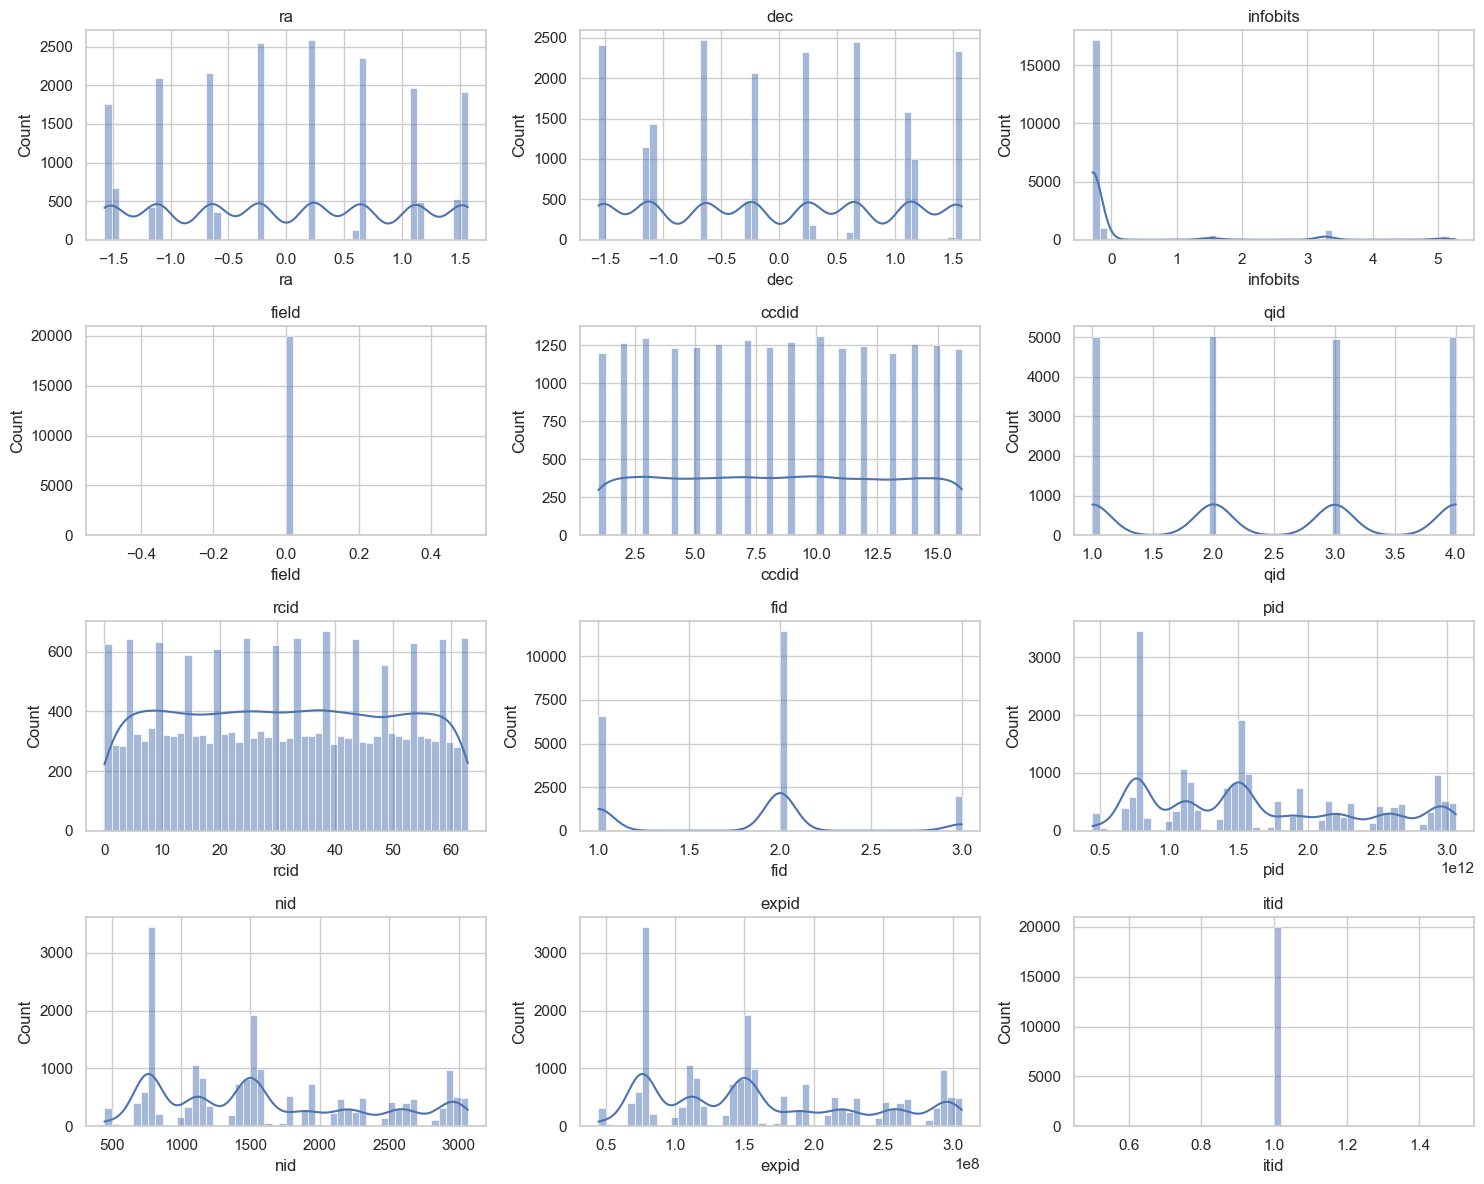

In [4]:
# Univariate: Histograms + KDEs for numeric columns (sampled if too many rows)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
print('Numeric columns count:', len(num_cols))
sample = df.sample(n=20000, random_state=42) if df.shape[0] > 20000 else df
cols_to_plot = num_cols[:12]  # limit to first 12 for brevity; change as needed
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,12))
axes = axes.flatten()
for i, c in enumerate(cols_to_plot):
    sns.histplot(sample[c].dropna(), kde=True, ax=axes[i], bins=50, color='C0')
    axes[i].set_title(c)
plt.tight_layout()
plt.show()

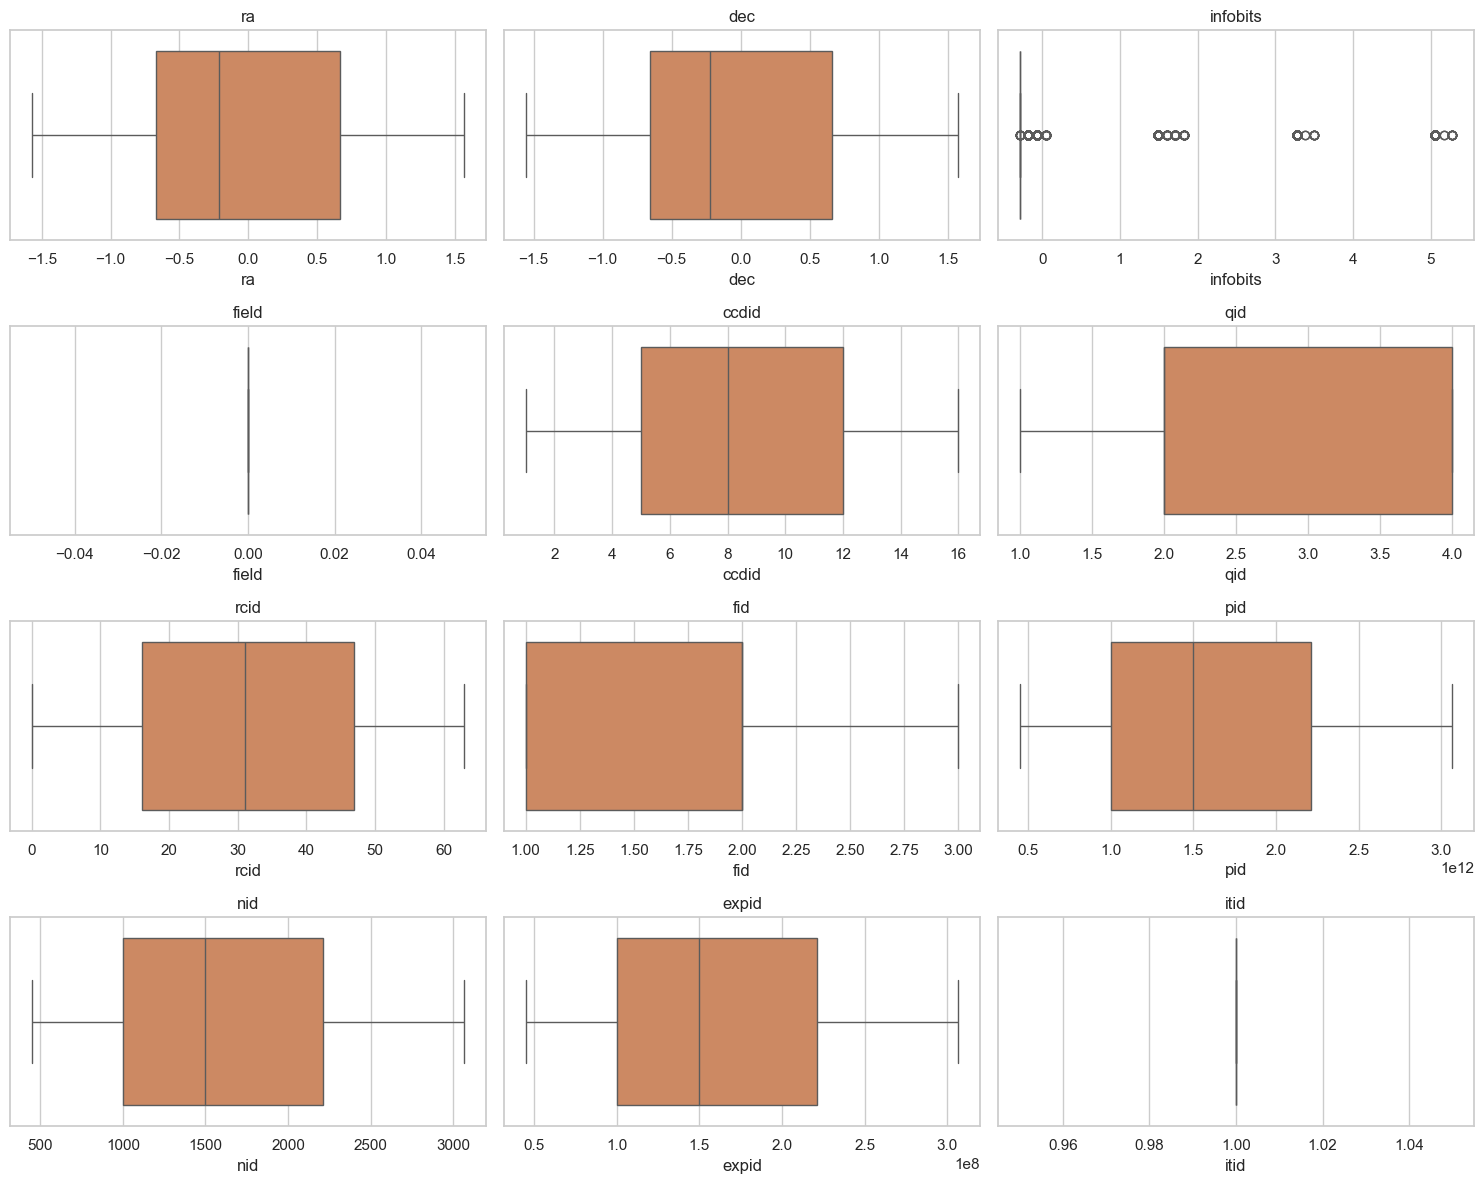

In [5]:
# Univariate: Boxplots to highlight outliers for the same numeric columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,12))
axes = axes.flatten()
for i, c in enumerate(cols_to_plot):
    sns.boxplot(x=sample[c].dropna(), ax=axes[i], color='C1')
    axes[i].set_title(c)
plt.tight_layout()
plt.show()

Categorical columns: ['filtercode', 'imgtype', 'imgtypecode', 'obsdate', 'ipac_pub_date']


C:\Users\NIPUN\AppData\Local\Temp\ipykernel_19184\184079033.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


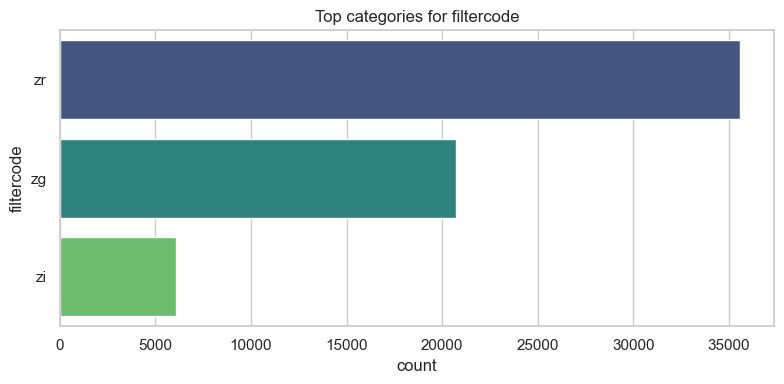

C:\Users\NIPUN\AppData\Local\Temp\ipykernel_19184\184079033.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


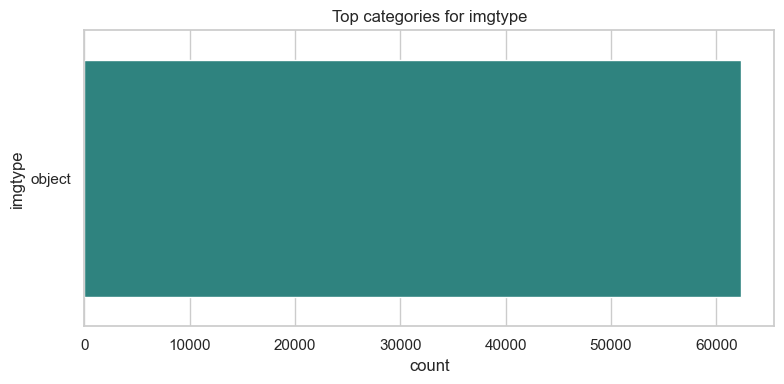

C:\Users\NIPUN\AppData\Local\Temp\ipykernel_19184\184079033.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


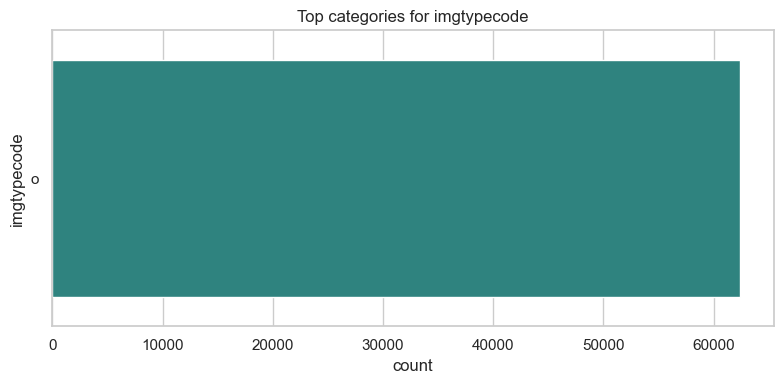

C:\Users\NIPUN\AppData\Local\Temp\ipykernel_19184\184079033.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


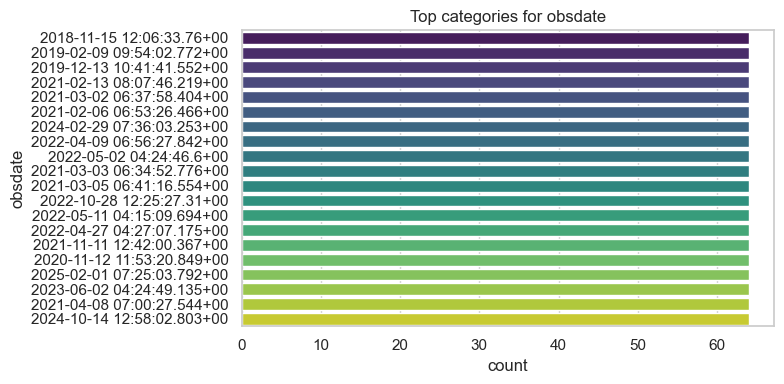

C:\Users\NIPUN\AppData\Local\Temp\ipykernel_19184\184079033.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


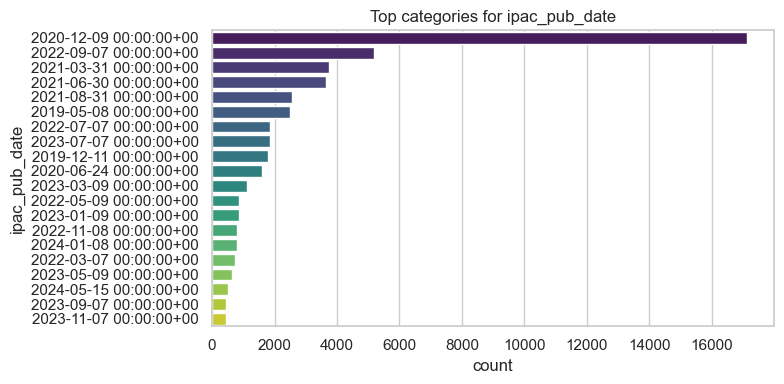

In [6]:
# Categorical / object columns: value counts and bar plots for top categories
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical columns:', cat_cols)
for c in cat_cols:
    vc = df[c].value_counts().nlargest(20)
    plt.figure(figsize=(8,4))
    sns.barplot(x=vc.values, y=vc.index, palette='viridis')
    plt.title(f'Top categories for {c}')
    plt.xlabel('count')
    plt.tight_layout()
    plt.show()

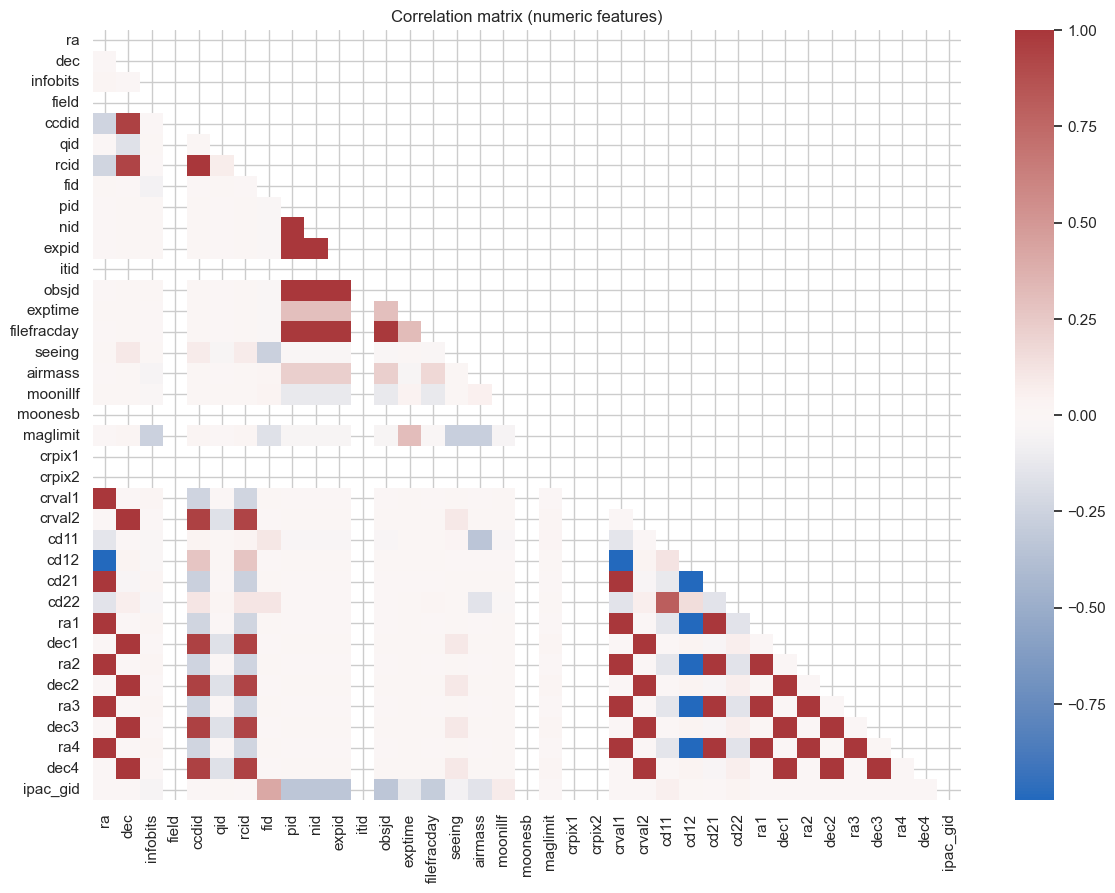

In [7]:
# Bivariate: Correlation heatmap of numeric features
corr = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(14,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='vlag', center=0, annot=False, fmt='.2f')
plt.title('Correlation matrix (numeric features)')
plt.show()

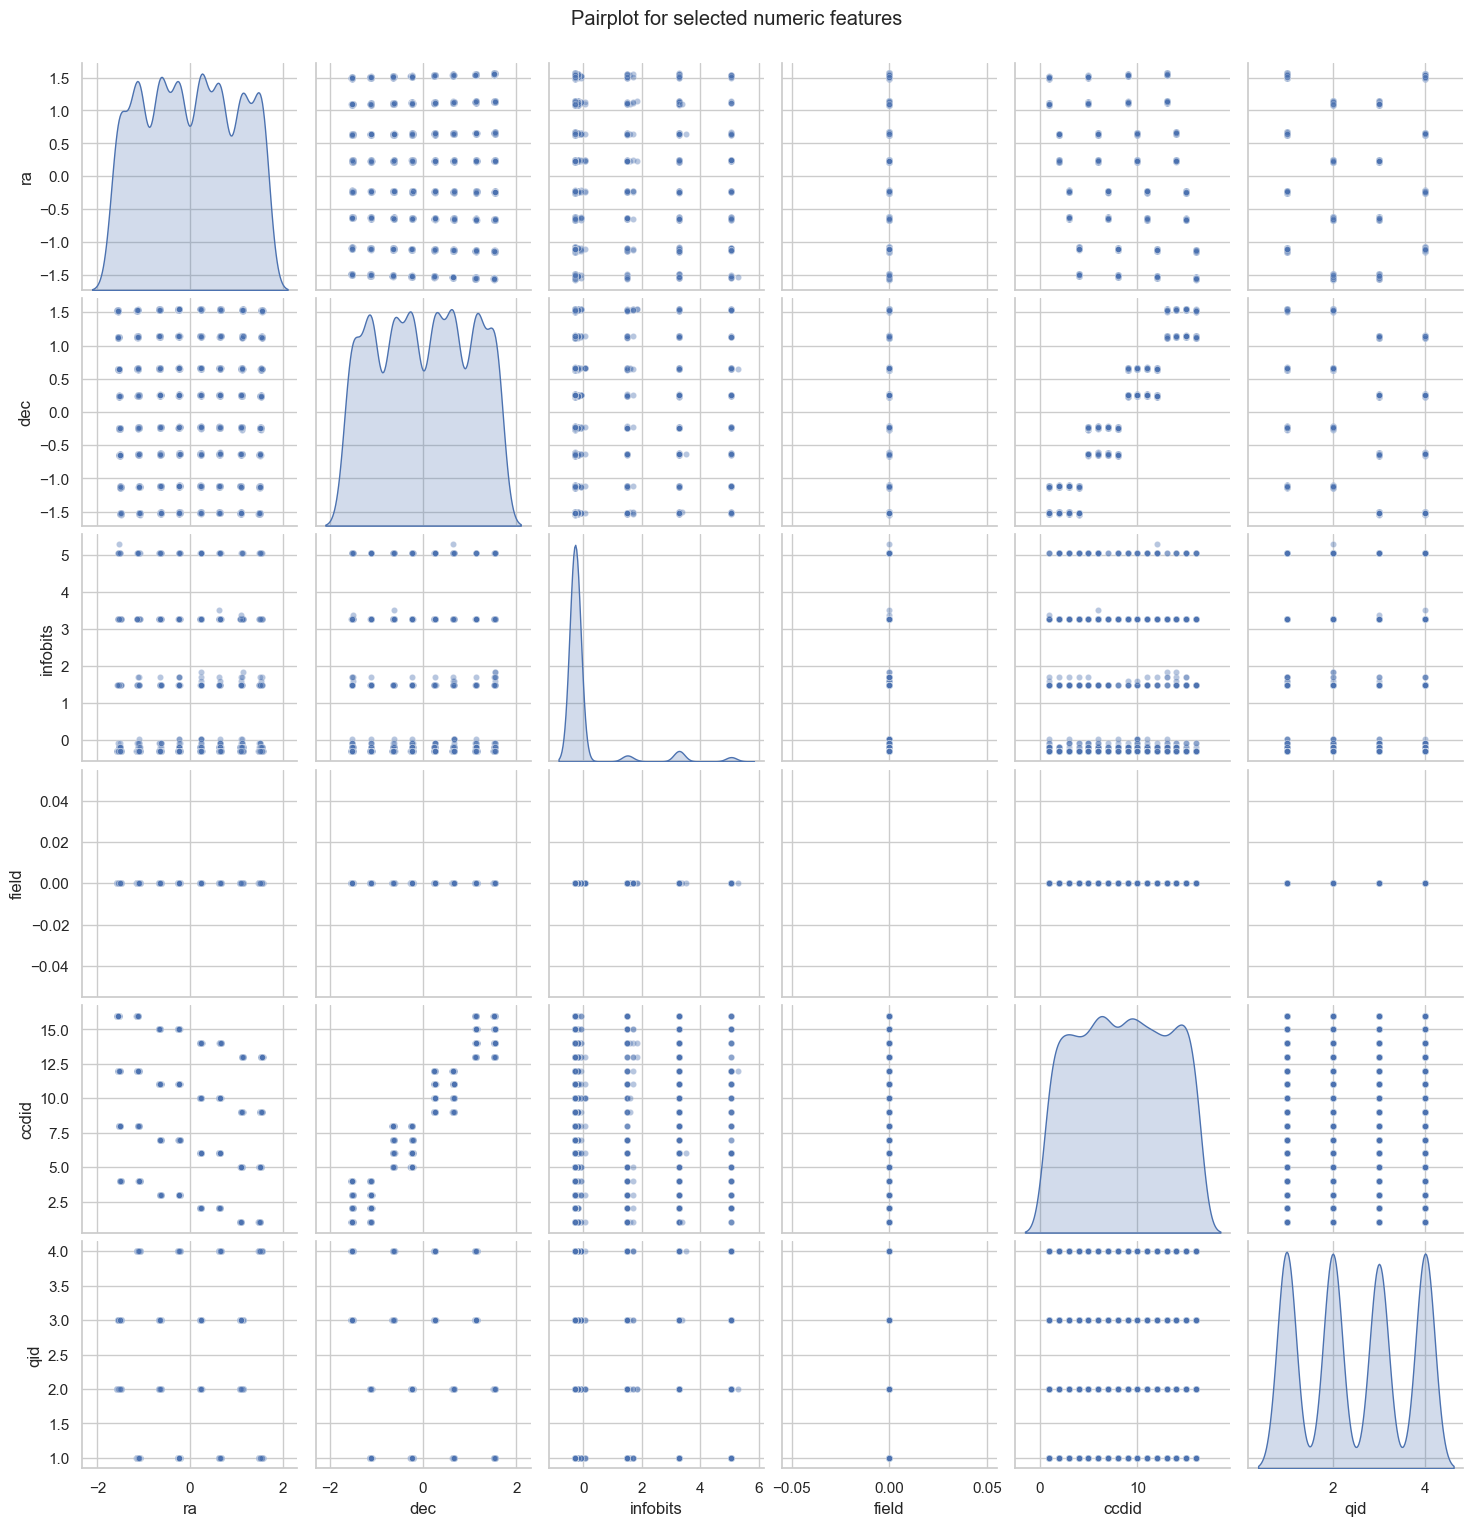

In [8]:
# Pairplot (pairwise relationships) for a small selection of variables
pair_cols = num_cols[:6] if len(num_cols) >= 6 else num_cols
pair_sample = df[pair_cols].sample(n=5000, random_state=42) if df.shape[0] > 5000 else df[pair_cols]
sns.pairplot(pair_sample.dropna(), diag_kind='kde', plot_kws={'alpha':0.4, 's':20})
plt.suptitle('Pairplot for selected numeric features', y=1.02)
plt.show()

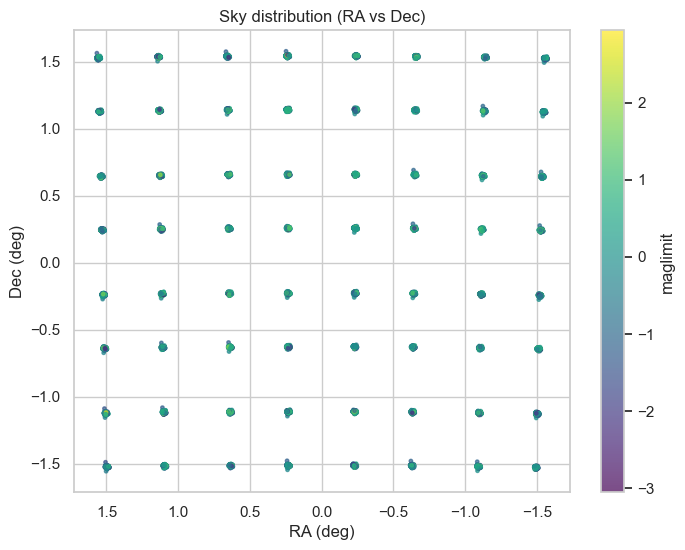

In [9]:
# Spatial: sky scatter (RA, Dec) colored by an example numeric feature if present
if set(['ra','dec']).issubset(df.columns):
    plt.figure(figsize=(8,6))
    color_col = None
    for candidate in ['maglimit','seeing','airmass','snr']:
        if candidate in df.columns:
            color_col = candidate
            break
    sample_sky = df.sample(n=20000, random_state=42) if df.shape[0] > 20000 else df
    if color_col:
        sc = plt.scatter(sample_sky['ra'], sample_sky['dec'], c=sample_sky[color_col], s=6, cmap='viridis', alpha=0.7)
        plt.colorbar(sc, label=color_col)
    else:
        plt.scatter(sample_sky['ra'], sample_sky['dec'], s=6, alpha=0.7)
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
    plt.title('Sky distribution (RA vs Dec)')
    plt.gca().invert_xaxis()  # common convention for sky maps
    plt.show()
else:
    print('RA/Dec columns not found; skipping sky scatter plot')

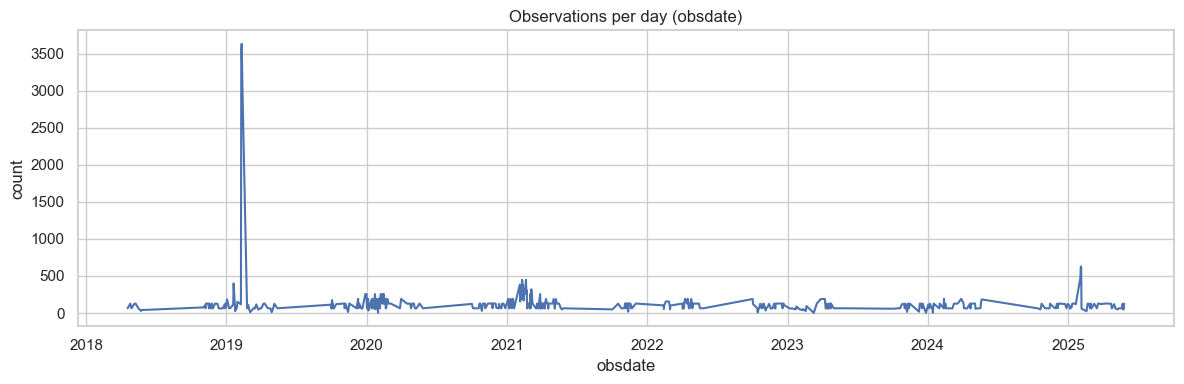

In [10]:
# Time series: observations per date if a date column exists
possible_date_cols = [c for c in df.columns if any(x in c.lower() for x in ['date','time','jd','mjd','obsdate'])]
if possible_date_cols:
    date_col = possible_date_cols[0]
    try:
        dts = pd.to_datetime(df[date_col], errors='coerce')
        counts = dts.dt.date.value_counts().sort_index()
        plt.figure(figsize=(12,4))
        counts.plot()
        plt.title(f'Observations per day ({date_col})')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Could not parse date column', date_col, e)
else:
    print('No date-like column found; skipping time-series plot')

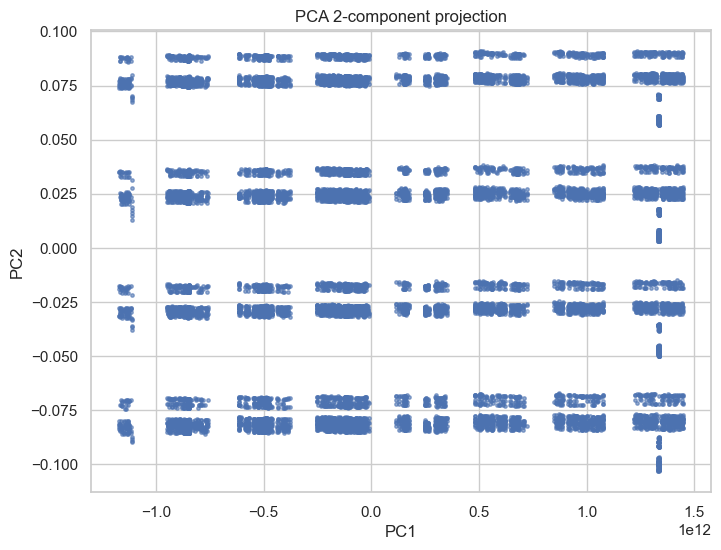

In [11]:
# Multivariate: PCA 2D projection
num_df = df.select_dtypes(include=['number']).dropna(axis=1, how='any')
if num_df.shape[1] >= 2:
    pca = PCA(n_components=2, random_state=42)
    sample_pca = num_df.sample(n=20000, random_state=42) if num_df.shape[0] > 20000 else num_df
    Xp = pca.fit_transform(sample_pca)
    plt.figure(figsize=(8,6))
    plt.scatter(Xp[:,0], Xp[:,1], s=6, alpha=0.6)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA 2-component projection')
    plt.show()
else:
    print('Not enough numeric features for PCA')

C:\Users\NIPUN\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\NIPUN\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\NIPUN\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


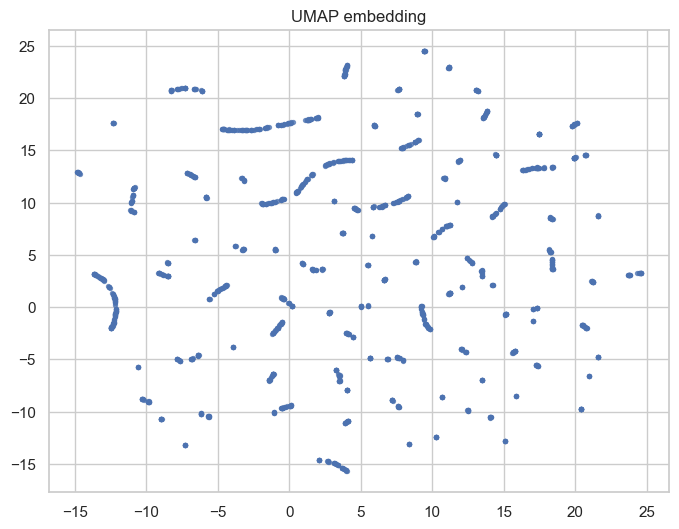

In [12]:
# Multivariate: t-SNE (or UMAP if available) — use a small sample for speed
num_df = df.select_dtypes(include=['number']).dropna(axis=1, how='any')
if num_df.shape[0] > 2000:
    sample_emb = num_df.sample(n=2000, random_state=42)
else:
    sample_emb = num_df
if sample_emb.shape[0] >= 50 and sample_emb.shape[1] >= 2:
    if _has_umap:
        reducer = umap.UMAP(n_components=2, random_state=42)
        emb = reducer.fit_transform(sample_emb)
        title = 'UMAP embedding'
    else:
        reducer = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
        emb = reducer.fit_transform(sample_emb)
        title = 't-SNE embedding'
    plt.figure(figsize=(8,6))
    plt.scatter(emb[:,0], emb[:,1], s=8, alpha=0.7)
    plt.title(title)
    plt.show()
else:
    print('Not enough data/features for embedding visualization')

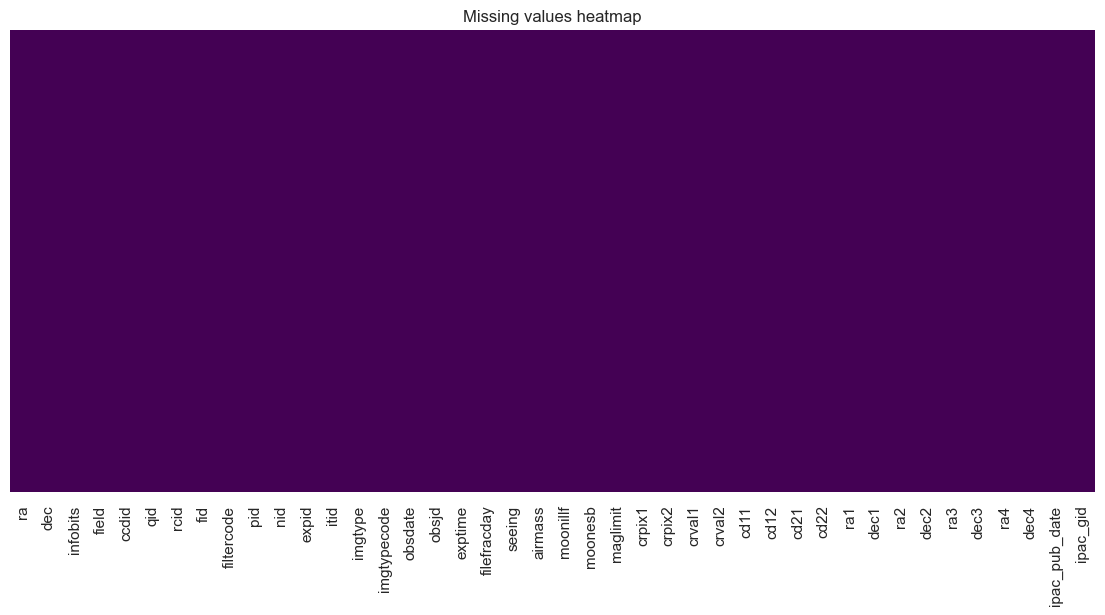

In [13]:
# Missingness heatmap
plt.figure(figsize=(14,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing values heatmap')
plt.show()

In [14]:
# Save sample figure outputs and create `figures/` folder
outdir = 'figures'
os.makedirs(outdir, exist_ok=True)
print('Figures directory:', outdir)
# Example: save correlation heatmap to file
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), cmap='vlag', center=0)
plt.title('Correlation matrix (saved)')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'correlation_matrix.png'), dpi=150)
plt.close()
print('Saved correlation_matrix.png')

Figures directory: figures
Saved correlation_matrix.png
Saved correlation_matrix.png


## Next steps
- Adjust `cols_to_plot` and sampling sizes to explore additional features.
- If you want interactive plots (zoom/pan), I can add Plotly versions of key plots.
- For reproducible model training, use the cleaned CSV and fit scalers/encoders on the training split only.